## SCALING AND NORMALIZATION : MIN-MAX SCALING (NORMALIZATION)

<br>

## Introduction

<br>
Min-Max scaling (often also simply called "normalization", a common cause for ambiguities) is a scaling technique that <b>maps the original data into a new range</b> by mean of the following linear transformation :

<br>
$
    \quad
    \boldsymbol{X_i}^{\star} 
    = \dfrac
        {\boldsymbol{X_i} - \operatorname{min}(\mathbf{X})}
        {\operatorname{max}(\mathbf{X}) – \operatorname{min}(\mathbf{X})}
      (\operatorname{max}^{\star} - \operatorname{min}^{\star}) + \operatorname{max}^{\star}
$

<br>
Linear Scaling to Unit Range is special case of min-max scaling in which $\operatorname{min}^{\star} = 0$ and $\operatorname{max}^{\star} = 1$. This linear transformation shrinks the original distribution such that the data points are now in the range [0,1] :

<br>
$
    \quad
    \boldsymbol{X_i}^{\star} 
    = \dfrac
        {\boldsymbol{X_i} - \operatorname{min}(\mathbf{X})}
        {\operatorname{max}(\mathbf{X}) – \operatorname{min}(\mathbf{X})}
$

<br>
The advantage of min-max normalization is that it <b>preserves the relationships among the original data points</b>.

<br>
Normalization works better for cases in which standardization might not work so well: if the distribution is not gaussian or the standard deviation is very small, the min-max scaler works better.

<br>
It must also be said that this scaling method is <b>sensitive to outliers</b>: normalizing the data will certainly scale to a very small interval; in presence of outliers we might want to consider Robust Scaling instead.


In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import math

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import utilcompute as uc
import utilplot as up
import preprocessing as pre
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM',    # per capita crime rate by town
    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',   # proportion of non-retail business acres per town
    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',     # nitric oxides concentration (parts per 10 million)
    'RM',      # average number of rooms per dwelling
    'AGE',     # proportion of owner-occupied units built prior to 1940
    'DIS',     # weighted distances to five Boston employment centres
    'RAD',     # index of accessibility to radial highways
    'TAX',     # full-value property-tax rate per $10,000
    'PTRATIO', # pupil-teacher ratio by town
    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',   # % lower status of the population
    'MEDV'     # median value of owner-occupied homes in $1000's
]


In [3]:
#df.describe()

In [4]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [5]:
# FEATURES SELECTION 

target = 'MEDV'
features = [c for c in df.columns if (c != target)]


In [6]:
# FEATURE SELECTION

# from now on, even though we'll run the model with all the features, 
# we'll scale only the following 

selected_features = ['RM', 'B', 'PTRATIO']


In [7]:
#results_cols_to_print = ['note'] + selected_features + ['r2']


In [8]:
# linear regression - ols

results = uc.compute_kfold_stats(
    df = df, 
    features = features,
    target = [target], 
    linear_model_name = 'LinearRegression', 
    linear_model_args = None,
    note = 'non-normal',
    task = 'regression')

#print(results[results_cols_to_print])


In [9]:
# linear regression - ols - selected features min-max scaling

non_selected_features = [f for f in features if (f not in selected_features)]
df_nrm = pre.normalize(df = df, included = selected_features, excluded = non_selected_features + [target])

results_temp = uc.compute_kfold_stats(
    df = df_nrm, 
    features = features,
    target = [target], 
    linear_model_name = 'LinearRegression', 
    linear_model_args = None,
    note = 'normal',
    task = 'regression')

results = results.append(results_temp).reset_index(drop = True)


## <font color='#28B463'>Impact on the transformed features

<br>

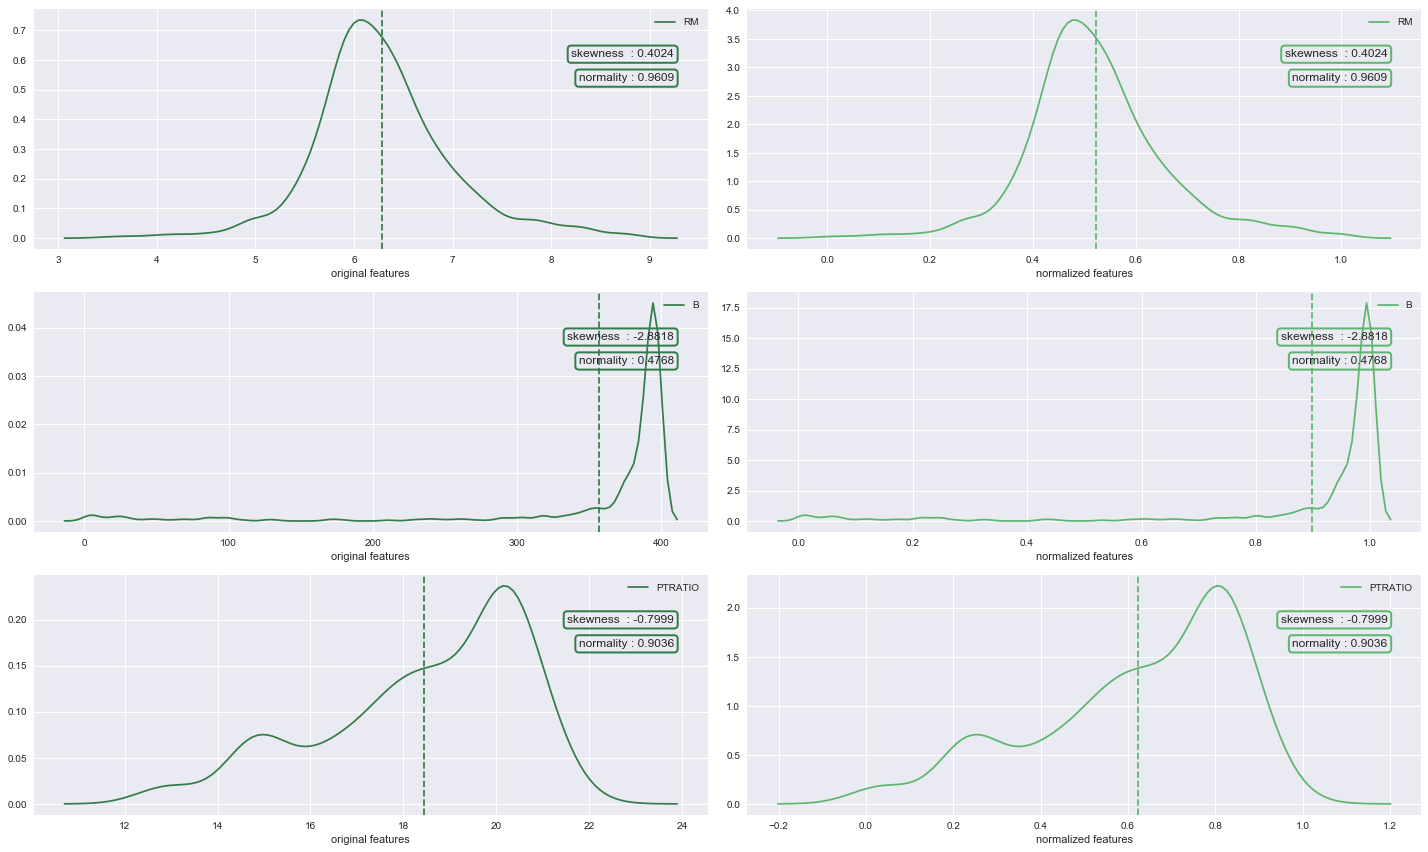

In [10]:
plot_list = [
    { 'df' : df,     'xlabel' : 'original features',   'legend_loc' : 'best'},
    { 'df' : df_nrm, 'xlabel' : 'normalized features', 'legend_loc' : 'best'}
]

visualized_features = selected_features

n_cols = len(plot_list)
fig, axs = plt.subplots(nrows = len(visualized_features), ncols = n_cols, figsize=(20, 4 * len(visualized_features)))    
pal = sns.color_palette("Greens_d", n_cols)

p = 0
for (pl_index, pl_dict) in enumerate(plot_list):      
    for (f_index,f) in enumerate(visualized_features) :
        ax = axs[f_index][pl_index] 
        subset = pl_dict['df'][f]       
        
        skewness = round(stats.skew(subset),4)
        normality = round(stats.shapiro(subset)[0],4)
        
        sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = f)   
        ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
        
        ax.text(x = 0.95, y = 0.8, horizontalalignment='right', s = ('skewness  : {0}'.format(skewness)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))
        ax.text(x = 0.95, y = 0.7, horizontalalignment='right', s = ('normality : {0}'.format(normality)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))        
        
        ax.set_xlabel(pl_dict['xlabel'])
        ax.legend(loc = pl_dict['legend_loc'])
    p += 1
        

plt.tight_layout()
plt.show()


## Impact on the intercept

<br>

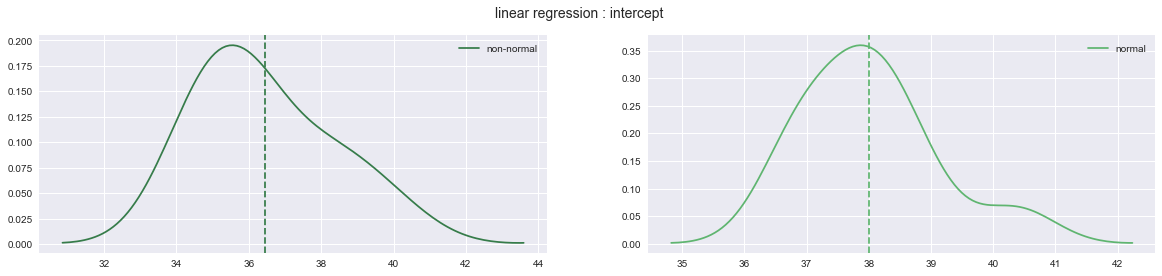

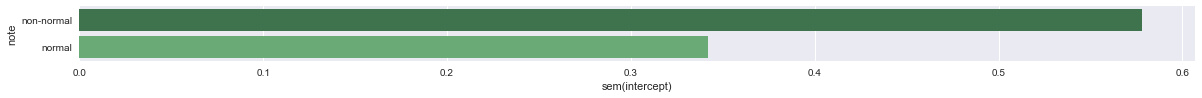

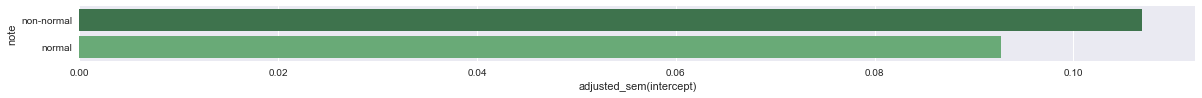

In [11]:
up.plot_across_discriminant(
    df = results, 
    cols = ['intercept'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

## Impact on the regression coefficients of the transformed features

<br>

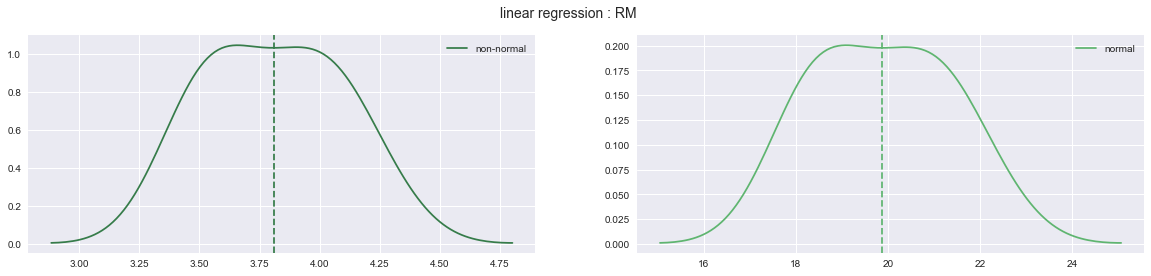

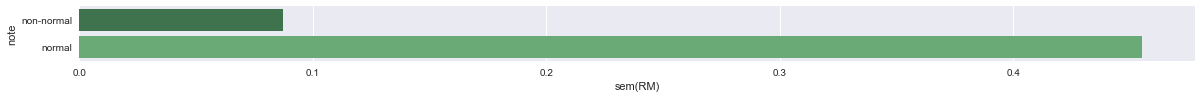

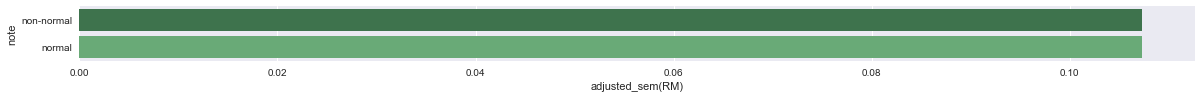

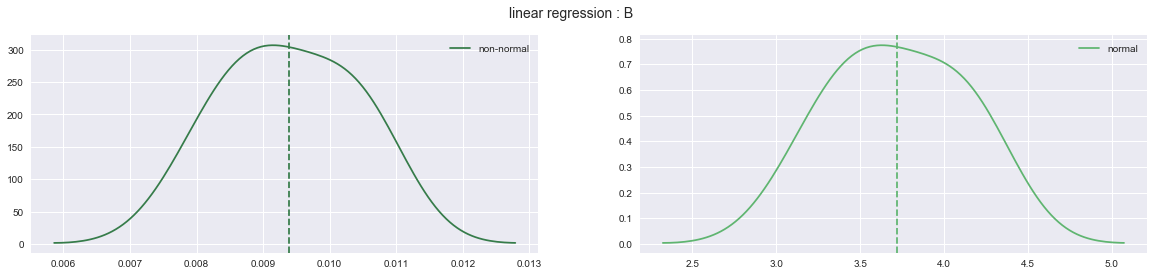

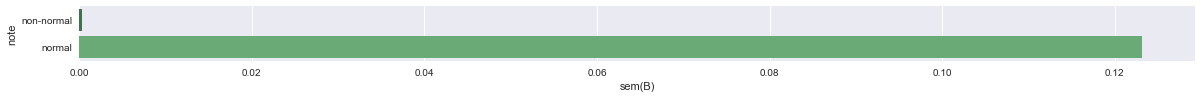

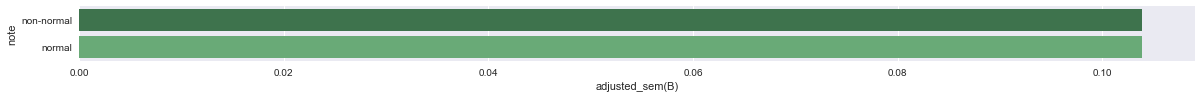

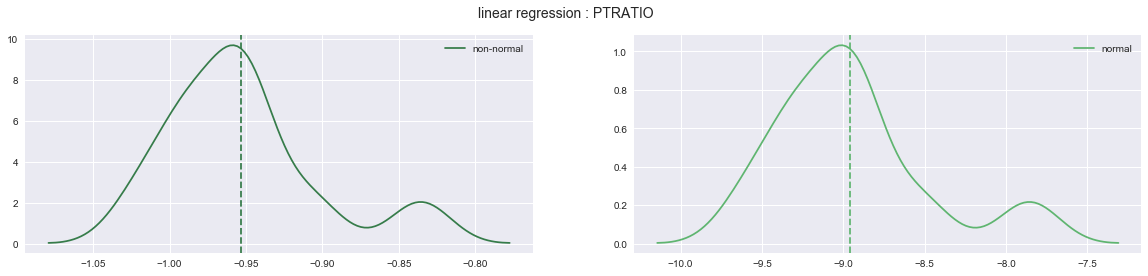

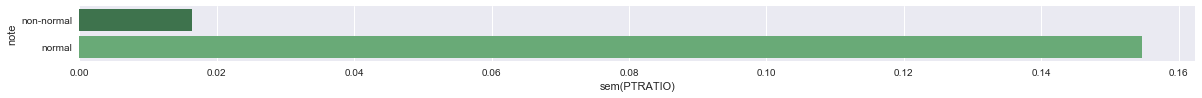

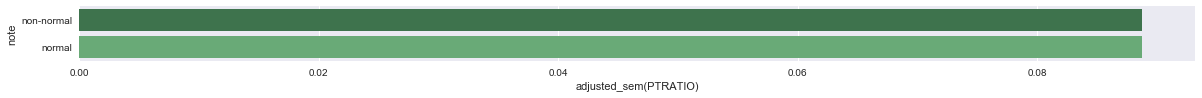

In [12]:
visualized_features = selected_features

up.plot_across_discriminant(
    df = results, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)    

## Impact on the regression coefficients of the non-transformed features

<br>
In the graphs below only three of the ten non-scaled feature are represented, but the plots all show the same result. 

<br>
The distributions of the regression coefficients have changed for the non-scaled features as well, but it's hard to tell if we are looking at a linear combination or something else, at least for the moment.

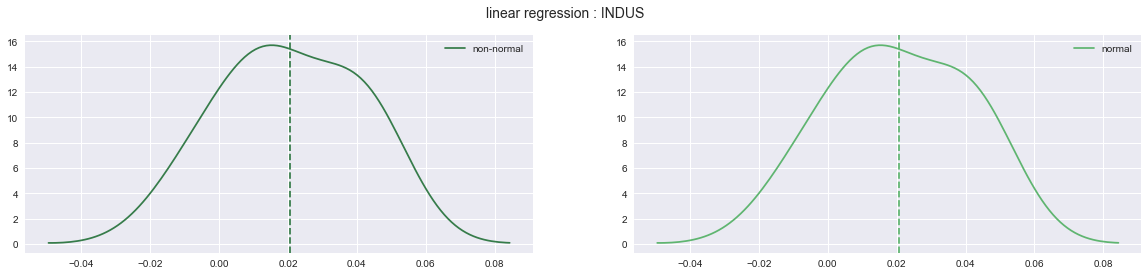

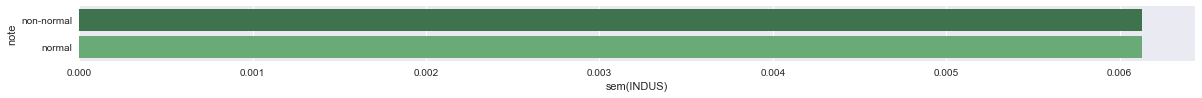

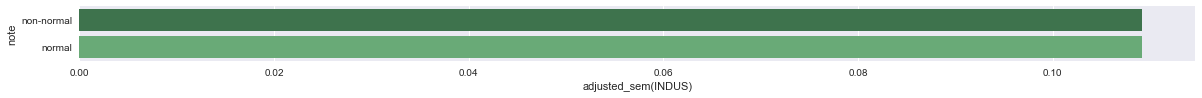

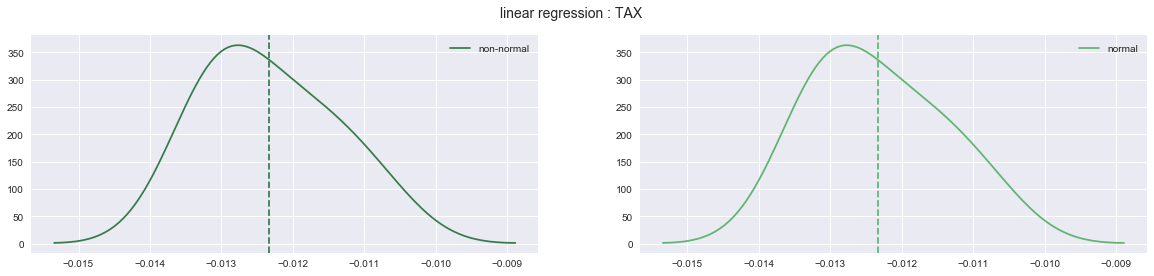

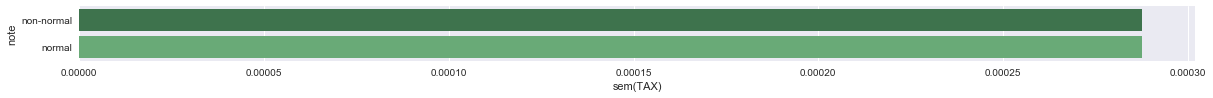

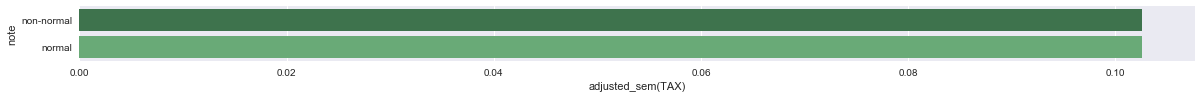

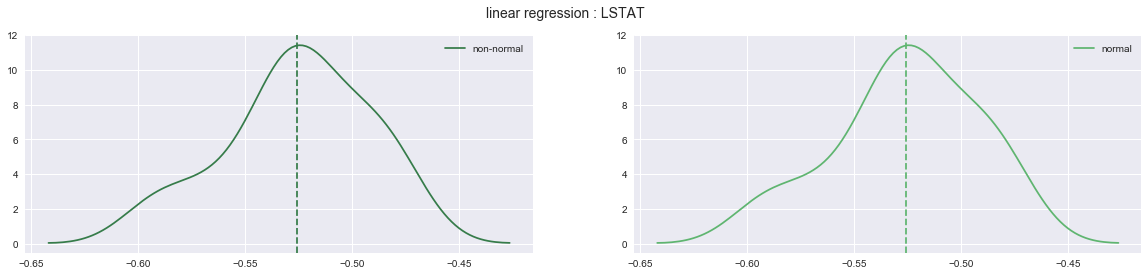

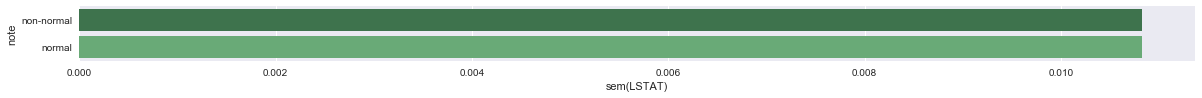

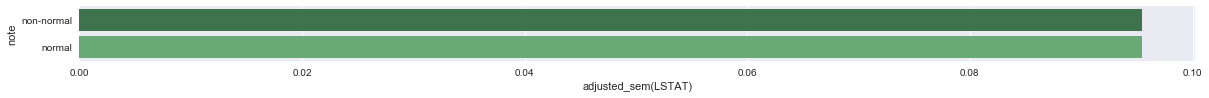

In [13]:
#non_selected_features = [f for f in features if (f not in selected_features)]
non_selected_features = ['INDUS', 'TAX', 'LSTAT']
visualized_features = non_selected_features

up.plot_across_discriminant(
    df = results, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)


## Impact on the regression score

<br>
The distribution of the regression scores has changed as well but it's hard to determine the underlying relationship (if that exists) just by looking at the plot below.


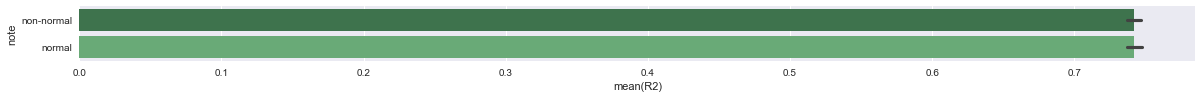

In [14]:
up.plot_across_discriminant(
    df = results, 
    cols = ['R2'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


## References

<br>
<ul style="list-style-type:square">
    <li>
         Sebastian Raschka - 
         <a href="https://bit.ly/1L0DPBW">
         About Feature Scaling and Normalization</a>        
    </li>
    <br>
    <li>
         Ben Alex Keen - 
         <a href="https://bit.ly/2H3JxVc">
         Feature Scaling with scikit-learn</a>        
    </li>
</ul>